# Visualization

## Pre-processing

### Calculate isotropic component and subtract

In [1]:
from mdx2.utils import loadobj, saveobj
import pandas as pd
import numpy as np

# copy geometry file over for convenience
!cp ../processing/mdx2/split_00/geometry.nxs ./

Crystal  = loadobj('geometry.nxs','crystal')
Symmetry = loadobj('geometry.nxs','symmetry')

def hkl2s(h,k,l):
    """Compute the magnitude of s from Miller indices."""
    UB = Crystal.ub_matrix
    s = UB @ np.stack((h,k,l))
    return np.sqrt(np.sum(s*s,axis=0))

def isInteger(h):
    return (h.round()-h).abs() < 0.00001

def isReflection(h,k,l):
    return isInteger(h) & isInteger(k) & isInteger(l) & Symmetry.is_reflection(h,k,l)

def calc_stats(fn):
    # load the tables and convert to pandas dataframe
    tab = loadobj(fn,'hkl_table')
    tab.s = hkl2s(tab.h,tab.k,tab.l)
    df = tab.to_frame()
    df = df[~isReflection(df['h'],df['k'],df['l'])]
    df = df.set_index(['h','k','l']).sort_index()
    s_bins = pd.cut(df['s'],np.linspace(0,.8,81))
    df_isoavg = df.groupby(s_bins).agg({
        's':'mean',
        'intensity':['mean','std'],
        'intensity_error':'mean'})
    
    dfh = tab.to_frame()
    dfh = dfh[isReflection(dfh['h'],dfh['k'],dfh['l'])]
    dfh = dfh.set_index(['h','k','l']).sort_index()
    s_bins = pd.cut(dfh['s'],np.linspace(0,.8,81))
    dfh_isoavg = dfh.groupby(s_bins).agg({
        's':'mean',
        'intensity':['mean','std'],
        'intensity_error':'mean'})
    df_out = pd.DataFrame({'s':df_isoavg['s']['mean'],'non-halo':df_isoavg['intensity']['mean'],'halo':dfh_isoavg['intensity']['mean']})
    df_out = df_out.set_index('s')
    return df_out
    
for dset in ['all','crystal1','crystal2']:
    df_stats = calc_stats(f'../processing/mdx2/merged_{dset}.nxs')
    nh = df_stats['non-halo'].dropna()
    x = nh.keys().values
    y = nh.values
    Imax = np.max(y)
    tab = loadobj(f'../processing/mdx2/merged_{dset}.nxs','hkl_table')
    tab.isoavg = np.interp(hkl2s(tab.h,tab.k,tab.l),x,y/Imax)
    tab.intensity/=Imax
    tab.intensity_error/=Imax
    tab.intensity -= tab.isoavg
    saveobj(tab,f'merged_{dset}_sub.nxs','hkl_table')

Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
Reading hkl_table from ../processing/mdx2/merged_all.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/merged_all.nxs
  importing as HKLTable from mdx2.data
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged_all_sub.nxs
Reading hkl_table from ../processing/mdx2/merged_crystal1.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/merged_crystal1.nxs
  importing as HKLTable from mdx2.data
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged_crystal1_sub.nxs
Reading hkl_table from ../processing/mdx2/merged_crystal2.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/merged_crystal2.nxs
  importing as HKLTable from mdx2.data
Exporting <class 'mdx2.data.HKLTable'> to nexus obj

### Create slices through reciprocal space

In [2]:
!mdx2.map geometry.nxs merged_all_sub.nxs --limits -70 70 -70 70 0 1 --signal isoavg --outfile slice_all_isoavg.nxs
!mdx2.map geometry.nxs merged_all_sub.nxs --limits -70 70 -70 70 0 1 --signal intensity --outfile slice_all.nxs
!mdx2.map geometry.nxs merged_crystal1_sub.nxs --limits -70 70 -70 70 0 1 --signal intensity --outfile slice_crystal1.nxs
!mdx2.map geometry.nxs merged_crystal2_sub.nxs --limits -70 70 -70 70 0 1 --signal intensity --outfile slice_crystal2.nxs

Reading hkl_table from merged_all_sub.nxs
  importing as HKLTable from mdx2.data
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
map region:
  h from -70.0 to 70.0 (421 grid points)
  k from -70.0 to 70.0 (421 grid points)
  l from 0.0 to 1.0 (4 grid points)
generating Miller index array
mapping Miller indices to asymmetric unit
looking up isoavg in data table
preparing output array
Exporting <class 'mdx2.geometry.GridData'> to nexus object
  writing isoavg to slice_all_isoavg.nxs
done!
Reading hkl_table from merged_all_sub.nxs
  importing as HKLTable from mdx2.data
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
map region:
  h from -70.0 to 70.0 (421 grid points)
  k from -70.0 to 70.0 (421 grid points)
  l from 0.0 to 1.0 (4 grid points)
generating Miller index array
mapping

## Figure 5

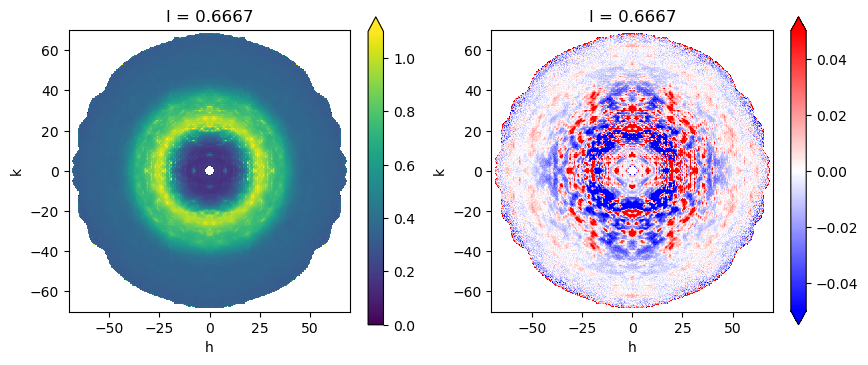

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
from nexusformat.nexus import nxload
# nexpy plots commented out (use xarray instead, see below)

imav = nxload('slice_all_isoavg.nxs')['/entry/isoavg']
imsub = nxload('slice_all.nxs')['/entry/intensity']

im = imsub + imav

#im[:,:,1].plot(aspect='equal',cmap='inferno',vmin=0,vmax=1.2)
#imav[:,:,1].plot(aspect='equal',cmap='inferno',vmin=0,vmax=1.2)
#imsub[:,:,1].plot(aspect='equal',cmap='bwr',vmin=-.05,vmax=.05)

imsub1 = nxload('slice_crystal1.nxs')['/entry/intensity']
imsub2 = nxload('slice_crystal2.nxs')['/entry/intensity']

#imsub1[300:391,240:301,1].plot(aspect='equal',cmap='bwr',vmin=-.05,vmax=.05)
#imsub2[300:391,240:301,1].plot(aspect='equal',cmap='bwr',vmin=-.05,vmax=.05)
#imd = imsub2 - imsub1
#imd[300:391,240:301,1].plot(aspect='equal',cmap='bwr',vmin=-.05,vmax=.05)

def map2xr(m):
    return xr.DataArray(
        data=m.signal.nxvalue,
        dims=m.axes,
        coords=dict(h=m.h.nxvalue, k=m.k.nxvalue, l=m.l.nxvalue)
    )

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

map2xr(im).isel(l=2).plot(x='h',y='k',ax=ax1,vmin=0,vmax=1.1,cmap='viridis')
map2xr(imsub).isel(l=2).plot(x='h',y='k',ax=ax2,vmin=-.05,vmax=.05,cmap='bwr')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

!mkdir -p figures
plt.savefig('figures/fig5ab.png',transparent=True)

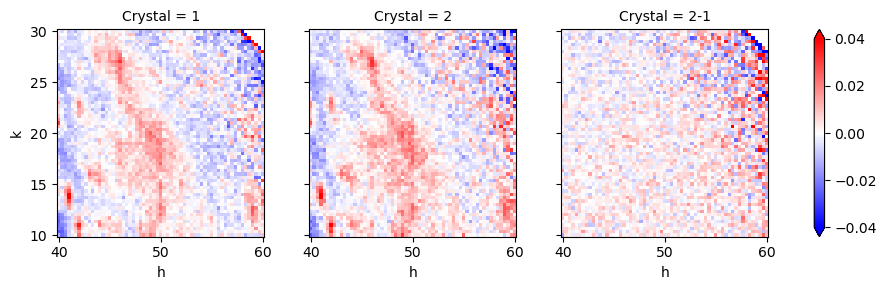

In [4]:
a = map2xr(imsub1).isel(l=2)
b = map2xr(imsub2).isel(l=2)
d = xr.concat((a,b,b-a),pd.Index(['1','2','2-1'],name="Crystal"))
fh = d[:,330:391,240:301].plot(x='h',y='k',col='Crystal',vmin=-.04,vmax=.04,cmap='bwr')
[ax.set_aspect('equal') for ax in fh.axs.flatten()]

!mkdir -p figures
plt.savefig('figures/fig5c.png',transparent=True)